# black-box regression results

Generates figures comparing performance on the black-box regression problems.

In [22]:
import pandas as pd
import json
import numpy as np
from glob import glob
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import os

matplotlib.rc('pdf', fonttype=42)
sns.set(font_scale=1.25, style='whitegrid')

rdir = '../results/'
rdir_new = '../results_new/'
figdir = '../../paper/figs/results_pmlb_r1/'
# Set to path to PMLB datasets
datadir = '../../../pmlb/datasets/'

print('figdir:',figdir)
def save(name='tmp',h=None):
    name = name.strip().replace(' ','-').replace('%','pct')
    if h == None:
        h = plt.gcf()
    h.tight_layout()
    print('saving',figdir+'/'+name+'.pdf')
    if not os.path.exists(figdir):
        os.makedirs(figdir)
    plt.savefig(figdir+'/'+name+'.pdf', bbox_inches='tight')
    
symbolic_algs = [
    'AFP', 
    'AFP_FE',
    'BSR',
    'DSR',
    'FFX',
    'FEAT',
    'EPLEX',
    'GP-GOMEA',
    'gplearn',
    'ITEA', 
    'MRGP', 
    'Operon',
    'SBP-GP',
    'AIFeynman',
    'HROCH_1s',
    'HROCH_10s',
    'HROCH_1m',
    'HROCH_5m',
    'HROCH_1MOPS',
    'RILS-ROLS_1s',
    'RILS-ROLS_10s',
    'RILS-ROLS_1m',
    'RILS-ROLS_5m',
    'RILS-ROLS_1MOPS',
]
nongp_algs = [
    'BSR',
    'DSR',
    'AIFeynman',
    'HROCH_1s',
    'HROCH_10s',
    'HROCH_1m',
    'HROCH_5m',
    'HROCH_1MOPS',
    'RILS-ROLS_1s',
    'RILS-ROLS_10s',
    'RILS-ROLS_1m',
    'RILS-ROLS_5m',
    'RILS-ROLS_1MOPS',
]
gp_algs = [
    'AFP', 
    'AFP_FE',
    'FFX',
    'FEAT',
    'EPLEX',
    'GP-GOMEA',
    'gplearn',
    'ITEA', 
    'MRGP', 
    'Operon',
    'SBP-GP',
]

figdir: ../../paper/figs/results_pmlb_r1/


# read data from feather

In [23]:
df_results_old = pd.read_feather(rdir+'/black-box_results.feather')

df_new = []
for root, _, files in os.walk(rdir_new):
    for file in files:
      if file.endswith('box_results.feather'):
        df_new.append(pd.read_feather(os.path.join(root, file)))

df_results = pd.concat([df_results_old, *df_new]).reset_index()

## summarize results by dataset, including ranking

In [24]:
df_results2 = df_results.merge(df_results.groupby('dataset')['algorithm'].nunique().reset_index(),
                              on='dataset',suffixes=('','_count'))

                                       
# rankings per trial per dataset
for col in [c for c in df_results2.columns if c.endswith('test') or c.endswith('size')]:
    ascending = 'r2' not in col
    df_results2[col+'_rank_per_trial']=df_results2.groupby(['dataset','random_state'],group_keys=False)[col].apply(lambda x: 
                                                                              round(x,3).rank(
                                                                              ascending=ascending))
    
df_sum = df_results2.groupby(['algorithm','dataset'],as_index=False).median(numeric_only=True)
df_sum['rmse_test'] = df_sum['mse_test'].apply(np.sqrt)
df_sum['log_mse_test'] = df_sum['mse_test'].apply(lambda x: np.log(1+x))
df_results = df_results2

# rankings and normalized scores per dataset
for col in [c for c in df_sum.columns if c.endswith('test') or c.endswith('size')]:
    ascending = 'r2' not in col
    df_sum[col+'_rank']=df_sum.groupby(['dataset'], group_keys=False)[col].apply(lambda x: 
                                                                        round(x,3).rank(ascending=ascending)
                                                                  )
    df_sum[col+'_norm'] = df_sum.groupby('dataset', group_keys=False)[col].apply(lambda x: (x-x.min())/(x.max()-x.min()))
###################
# save summary data
###################
df_sum.to_csv(rdir+'results_black-box_summary.csv.gz',compression='gzip',index=False)

df_sum

,algorithm,dataset,index,random_state,training time (s),model_size,mse_test,mae_test,r2_test,training time (hr),...,mae_test_rank,mae_test_norm,r2_test_rank,r2_test_norm,r2_zero_test_rank,r2_zero_test_norm,rmse_test_rank,rmse_test_norm,log_mse_test_rank,log_mse_test_norm
0,AFP,1027_ESL,14.5,13879.5,1210.966865,20.5,0.365049,0.442612,0.830930,0.336380,...,16.5,0.264768,16.0,0.922184,16.0,0.922184,16.0,0.139514,16.0,0.123830
1,AFP,1028_SWD,224.5,13879.5,3017.658321,47.0,0.438023,0.538419,0.314517,0.838238,...,20.0,0.374282,16.0,0.815176,16.0,0.785806,19.0,0.216281,19.0,0.208446
2,AFP,1029_LEV,434.5,13879.5,2622.206193,23.5,0.433124,0.508817,0.521904,0.728391,...,15.0,0.093695,16.0,0.939429,16.0,0.934869,16.0,0.075124,16.0,0.070675
3,AFP,1030_ERA,644.5,13879.5,3007.024177,36.5,2.496171,1.299746,0.358716,0.835284,...,19.0,0.157189,17.0,0.919178,17.0,0.917586,16.0,0.066810,16.0,0.070855
4,AFP,1089_USCrime,854.5,13879.5,590.939726,25.0,549.423049,18.823004,0.639671,0.164150,...,15.0,0.226948,17.0,0.822717,17.0,0.780937,16.0,0.200320,16.0,0.286474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2782,gplearn,695_chatfield_4,24400.5,13879.5,28398.484904,1.0,311.234213,11.696317,0.843542,7.888468,...,2.0,0.002471,5.0,0.997885,5.0,0.974512,8.0,0.010673,8.0,0.038788
2783,gplearn,706_sleuth_case1202,24610.5,13879.5,22506.032915,11.5,3185.450642,40.642813,0.661283,6.251676,...,5.0,0.011345,2.0,0.999864,2.0,0.994737,4.0,0.009024,4.0,0.029265
2784,gplearn,712_chscase_geyser1,24820.5,13879.5,26863.988673,3.0,36.237705,4.901875,0.760493,7.462219,...,2.0,0.003243,5.0,0.995754,5.0,0.993841,1.0,0.000000,1.0,0.000000
2785,gplearn,banana,25030.5,13879.5,31580.997657,33.5,0.421351,0.430139,0.571803,8.772499,...,10.0,0.218451,13.0,0.898714,13.0,0.786982,13.0,0.158092,13.0,0.142943


# plot comparisons

In [25]:
def compare(df_compare, x='r2_test',y='algorithm', row=None, col=None, scale=None, xlim=[],**kwargs):
    plt.figure()
    order = df_compare.groupby(y)[x].median().sort_values(ascending=False).index
    if scale=='log' and len(xlim)>0 and xlim[0] == 0:
        df_compare.loc[:,x] += 1
        xlim[0] = 1
        xnew = '1 + '+x
        df_compare=df_compare.rename(columns={x:xnew})
        x = xnew
    
    sns.catplot(data=df_compare, 
                kind='point',
#                 color='w',
                y=y,
                x=x,
                order=order,
                fliersize=0,
#                 notch=True,
                row=row,
                col=col,
                palette='flare_r',
                **kwargs
               )
    plt.ylabel('')
    if len(xlim)>0:
        plt.xlim(xlim[0],xlim[1])
    if scale:
        plt.gca().set_xscale(scale)
    
    save(name='_'.join(['cat-boxplot',x + '-by-'+ y]) )
    if col:
        save(name='_'.join(['cat-boxplot',x + '-by-'+ y] + [col]) )

## point plot comparisons on PMLB

C:\Users\Sebi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\axisgrid.py:1615: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  func(x=x, y=y, **kwargs)
C:\Users\Sebi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\axisgrid.py:1615: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  func(x=x, y=y, **kwargs)
C:\Users\Sebi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\axisgrid.py:1615: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  func(x=x, y=y, **

saving ../../paper/figs/results_pmlb_r1//pairgrid-pointplot_r2_test_model_size_training-time-(s).pdf


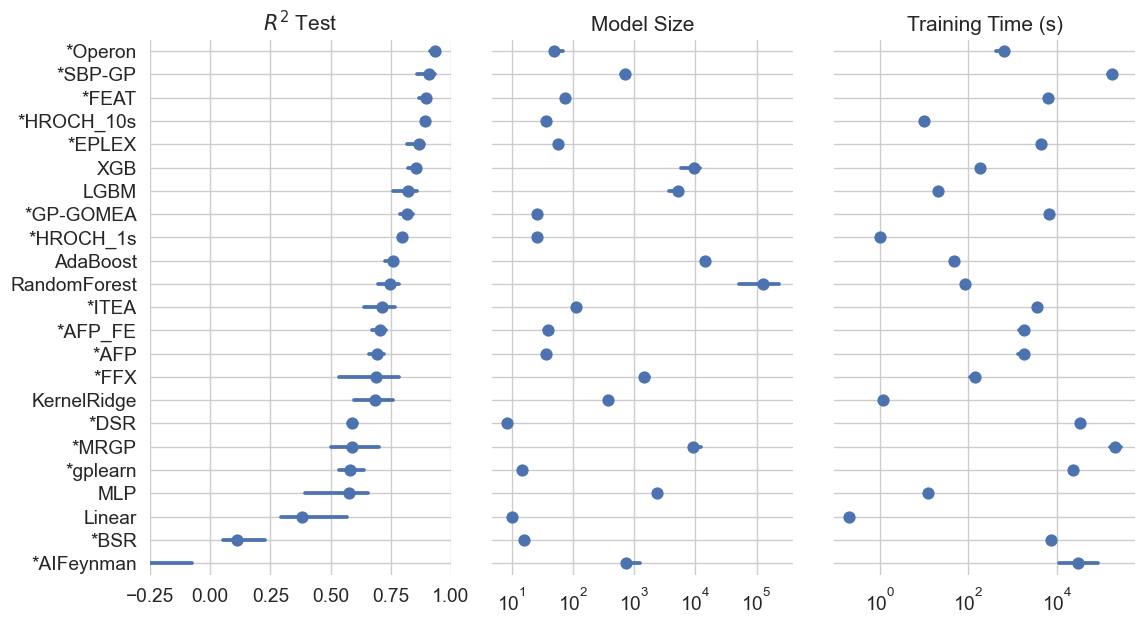

In [26]:
# Make the PairGrid
sns.set_style("whitegrid")
df_plot=df_sum.copy()

df_plot['*algorithm*'] = df_plot['algorithm'].apply(lambda x: '*'+x if x in symbolic_algs else x)
# different options
x_vars=[
#         'rmse_test',
#         'log_mse_test',
#         'r2_test_norm',
        'r2_test',
#         'r2_test_rank',
        'model_size',
#         'model_size_rank',
        'training time (s)',
]
order = df_plot.groupby('*algorithm*')[x_vars[0]].median().sort_values(
                    ascending='r2' not in x_vars[0] or 'rank' in x_vars[0]).index
g = sns.PairGrid(df_plot, 
                 x_vars=x_vars,
                 y_vars=['*algorithm*'],
                 height=6.5, 
                 aspect=0.6,
#                  hue='symbolic_dataset'
                )

# Draw a dot plot 
g.map(sns.pointplot, 
      #size=10,
      orient="h",
      #jitter=False,
      order=order,
      palette="flare_r",
      #linewidth=1,
      #markeredgecolor='w',
      join=False,
      estimator=np.median,
      n_boot=1000,
      #ci=95
      errorbar=('ci', 95)
     )
# # Use semantically meaningful titles for the columns
titles = [x.replace('_',' ').title().replace('(S)','(s)').replace('R2','$R^2$') for x in x_vars]
g.axes.flat[0].set_ylabel('')
for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)
    ax.set_xlabel('')
    
    if any([n in title.lower() for n in ['size','time']]):
        ax.set_xscale('log')
    
    if title == '$R^2$ Test':
        ax.set_xlim([-.25,1])

    # Make the grid horizontal instead of vertical
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

save(name='_'.join(['pairgrid-pointplot']+x_vars))

## effect of friedman datasets

C:\Users\Sebi\AppData\Local\Temp\ipykernel_12400\2643259289.py:17: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  g = sns.pointplot(ax=ax,
C:\Users\Sebi\AppData\Local\Temp\ipykernel_12400\2643259289.py:32: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  g2 = sns.pointplot(ax=ax,


saving ../../paper/figs/results_pmlb_r1//friedman_comparison_pairgrid-pointplot_normalized_R2_test.pdf


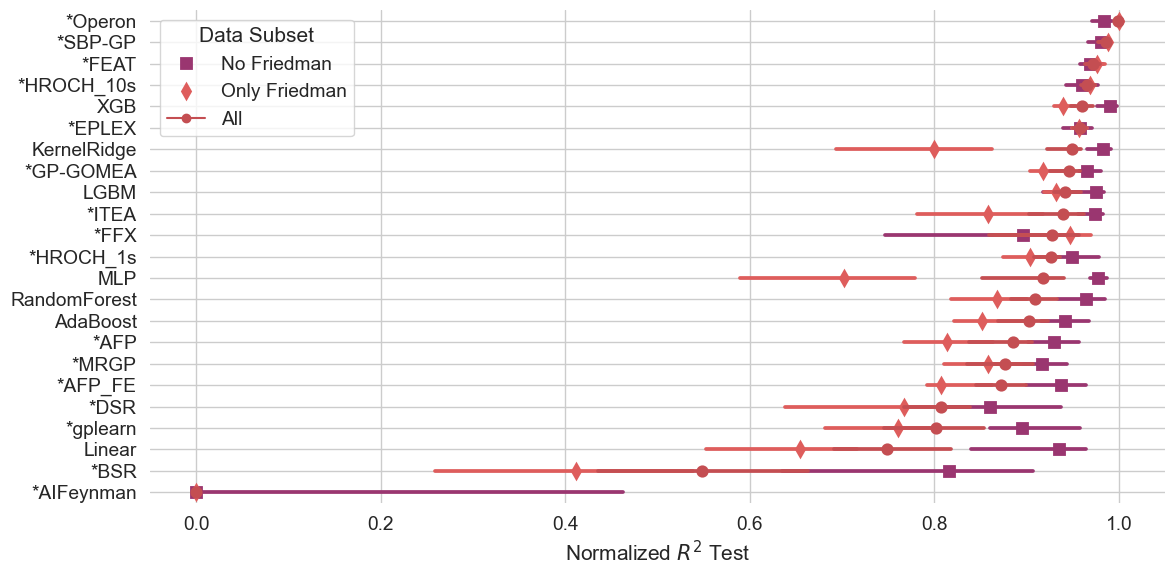

In [27]:
# Make the PairGrid
sns.set_style("whitegrid")
df_plot=df_sum.copy()
df_plot['*algorithm*'] = df_plot['algorithm'].apply(lambda x: '*'+x if x in symbolic_algs else x)
df_plot = df_plot[['*algorithm*','r2_test','r2_test_norm','r2_test_rank','friedman_dataset']]

x='r2_test'
markers = ['o','s','x']
colors = sns.color_palette('flare',n_colors=3)
for x in ['r2_test_norm']:
    h = plt.figure(figsize=(12,6))
    ax = plt.gca()
    order = df_plot.groupby('*algorithm*')[x].median().sort_values(
                    ascending='r2' not in x or 'rank' in x).index
    i = 0
    axes = []
    g = sns.pointplot(ax=ax,
                  data=df_plot,
                  x=x,
                  y='*algorithm*',
                  hue='friedman_dataset',
                  #size=10,
                  orient="h",
                  order=order,
                  markers=['s','d'],
                  palette="flare_r",
                  join=False,
                  estimator=np.median,
                  #legend_out=True
                 )
    # all PMLB
    g2 = sns.pointplot(ax=ax,
                  data=df_plot,
                  x=x,
                  y='*algorithm*',
#                   hue='friedman_dataset',
                  #size=10,
                  orient="h",
                  order=order,
                  color='r',
#                   palette="flare_r",
                  join=False,
                  estimator=np.median,
                  #markers = ['o'],
                  #legend_out=True
                 )
    # add all PMLB to legend
    handles, labels = ax.get_legend_handles_labels()
    #Create custom artists
    both = plt.Line2D((0,1),(0,0), color='r', marker='o', linestyle='-', label='All')
    handles.append(both)
    plt.legend(title='Data Subset',
               handles=handles, 
               labels=['No Friedman','Only Friedman','All'])
    
    if x=='r2_test':
        plt.xlim([-.5,1.0])
    if 'norm' in x:
        x='normalized_R2_test'
    sns.despine(left=True, bottom=True)
#         plt.title(prefix.replace('_',' ').title())
    axes.append(ax)
    i+=1
    plt.tight_layout()
    for ax in axes:
        ax.set_ylabel('')
        ax.set_xlabel(x.replace('_',' ').title().replace('(S)','(s)').replace('R2','$R^2$'))
        ax.yaxis.grid(True)
        ax.xaxis.grid(True)


    save(name='friedman_comparison_'+'_'.join(['pairgrid-pointplot']+[x]))

<!-- # scores on symbolic datasets (prelim) -->

# Pareto plot

Plot the method results as trade-offs between accuracy and simplicity

In [28]:
np.random.seed(42)
def bootstrap(val, n = 1000, fn=np.mean):
    val_samples = []
    for i in range(n):
        sample = np.random.randint(0,len(val)-1, size=len(val))
        val_samples.append( fn(val[sample]) )
    m = np.mean(val_samples)
    sd = np.std(val_samples)
    ci_upper  = np.quantile(val_samples,0.95)
    ci_lower  = np.quantile(val_samples,0.05)
    return m, sd, ci_upper,ci_lower

PF: [5, 11, 9, 10, 18]
PF: [15, 22, 0, 1, 6, 7, 20]
PF: [4, 12, 13, 14, 21]
PF: [2, 8, 3]
PF: [16, 19]
PF: [17]
saving ../../paper/figs/results_pmlb_r1//pareto_plot_r2_test_rank_model_size_rank.pdf


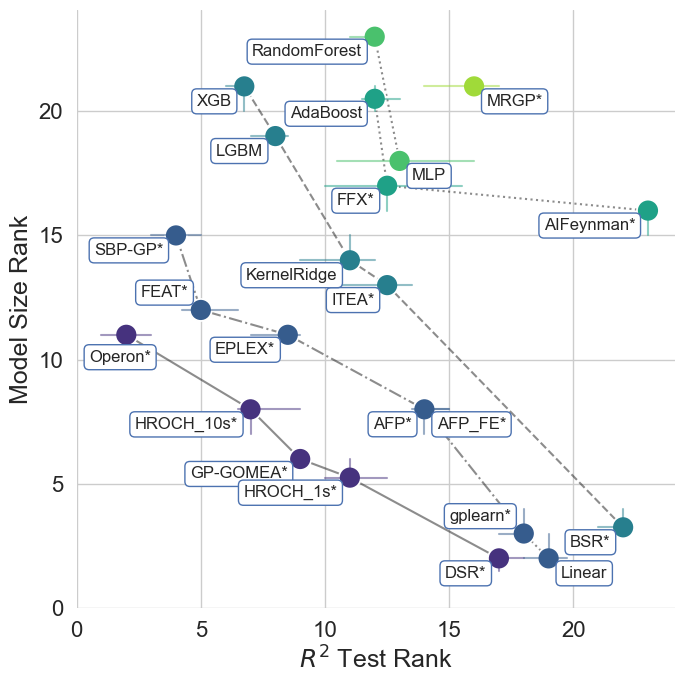

In [29]:
import pdb
from pareto_utils import front
sns.set(font_scale=1, style='whitegrid')
labelsize=18
plt.figure(figsize=(7,7))
data = df_sum.copy() #.loc[df_sum.algorithm.isin(symbolic_algs)]
data['*algorithm*'] = data['algorithm'].apply(lambda x: x+'*' if x in symbolic_algs else x)
xcol = 'r2_test_rank'
# xcol  = 'r2_test'
ycol = 'model_size_rank'
# ycol = 'model_size'
palette = 'viridis'
# outline pareto front
pareto_data = data.groupby('*algorithm*').median(numeric_only=True)

objs = pareto_data[[xcol,ycol]].values
# reverse R2 (objs are minimized)
# objs[:,0] = -objs[:,0]
levels = 6
styles=['-','-.','--',':', ':', ':']
PFs = []
pareto_ranks = -np.ones(len(pareto_data))
for el in range(levels):
#     pdb.set_trace()
    PF = front(objs[:,0],objs[:,1])
    if len(PF)>0:
        print('PF:',PF)
        pareto_ranks[PF] = el
    objs[PF,:] = np.inf
    PFs.append(PF)
i = 0
pareto_data.loc[:,'pareto_rank'] = pareto_ranks
for pfset in PFs:
    xset,yset = [],[]

    for pf in pfset:
        xset.append(pareto_data[xcol].values[pf])
        yset.append( pareto_data[ycol].values[pf] )
    linestyle=styles[i]
    plt.plot(xset,yset, styles[i]+'k', alpha=0.5, zorder=1)
#     plt.gca().set_zorder(10)
    i+=1

cmap = sns.color_palette(palette=palette, 
                         n_colors=pareto_data.pareto_rank.nunique(), 
                         desat=None, 
                         as_cmap=False)

ax = sns.scatterplot(
    ax = plt.gca(),
#     ax = g.ax_joint,
#     data = data.groupby('*algorithm*').median(),
    data = pareto_data,
    x = xcol,
    y = ycol,
#     style='*algorithm*',
#     style='pareto_rank',
    hue = 'pareto_rank',
    s=250,
#     palette=palette,
    #     edgecolor='k'
    legend=False,
    palette=cmap
)
ax.set_zorder(2)
xoff = .5
yoff = 0.3
# xoff, yoff = 0, 0
for idx,row in pareto_data.iterrows():
    x=row[xcol]-xoff
    y=row[ycol]-yoff
    ha='right'
    
    if idx in ['Linear','AFP_FE*','MLP','MRGP*']:
        x=row[xcol]+xoff
        ha='left'
    elif idx == 'Operon*':
        x = row[xcol]+1
        y -= yoff
    elif idx in ['gplearn*','FEAT*']:
#         x -= xoff
#         x=row[xcol]+xoff
        y = row[ycol]+1
#         ha='left'
        
    plt.text(s=idx,
             x = x, 
             y = y,
             ha=ha,
             va='top',
             bbox=dict(facecolor='w', edgecolor='b', boxstyle='round', alpha=1)
            )
    
# confidence intervals
i = 0
for alg, dg in data.groupby('*algorithm*'):
    x = dg[xcol].median() 
    y = dg[ycol].median()
    _, sdx, ciux, cilx = bootstrap(dg[xcol].values, fn=np.median, n=1000)
    _, sdy, ciuy, cily = bootstrap(dg[ycol].values, fn=np.median, n=1000)
    plt.plot(
             [cilx,ciux],
             [y, y],
             alpha=0.5,
             color=cmap[int(pareto_data.loc[alg,'pareto_rank'])]
#              color='b'
            )
    plt.plot(
             [x, x],
             [cily,ciuy],
             alpha=0.5,
             color=cmap[int(pareto_data.loc[alg,'pareto_rank'])]
#              color='b'
            )
    i += 1
ax.set_aspect(1.0)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ticksize=16
plt.xticks([0,5,10,15,20],fontsize=ticksize)
plt.yticks([0,5,10,15,20],fontsize=ticksize)
# ax.set_yscale('log')
plt.xlabel(xcol.replace('_',' ').replace('r2','$R^2$').title(), fontsize=labelsize)
plt.ylabel(ycol.replace('_',' ').title(), fontsize=labelsize)
sns.despine(left=True, bottom=True)
save(name="pareto_plot_"+xcol+'_'+ycol)

In [30]:
pareto_data['pareto_rank']

*algorithm*
AFP*            1.0
AFP_FE*         1.0
AIFeynman*      3.0
AdaBoost        3.0
BSR*            2.0
DSR*            0.0
EPLEX*          1.0
FEAT*           1.0
FFX*            3.0
GP-GOMEA*       0.0
HROCH_10s*      0.0
HROCH_1s*       0.0
ITEA*           2.0
KernelRidge     2.0
LGBM            2.0
Linear          1.0
MLP             4.0
MRGP*           5.0
Operon*         0.0
RandomForest    4.0
SBP-GP*         1.0
XGB             2.0
gplearn*        1.0
Name: pareto_rank, dtype: float64

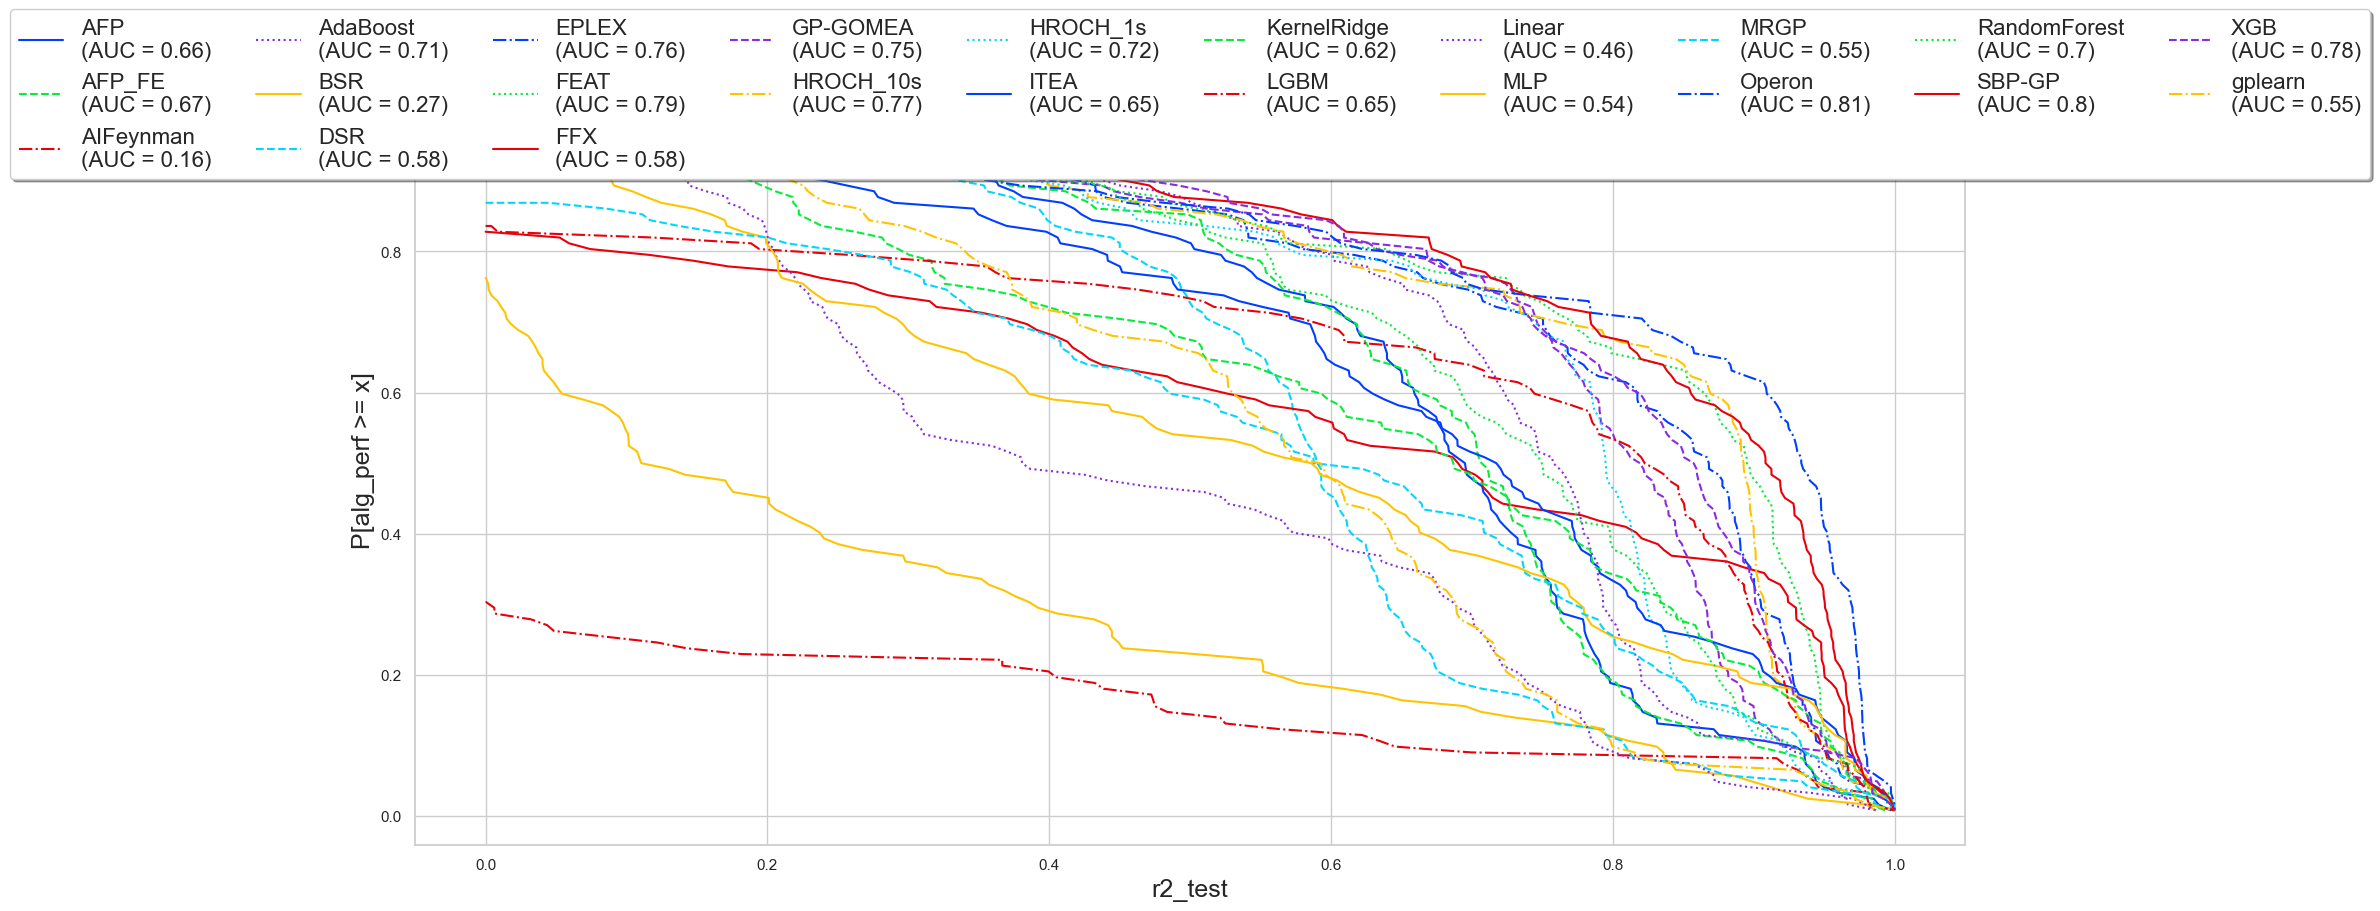

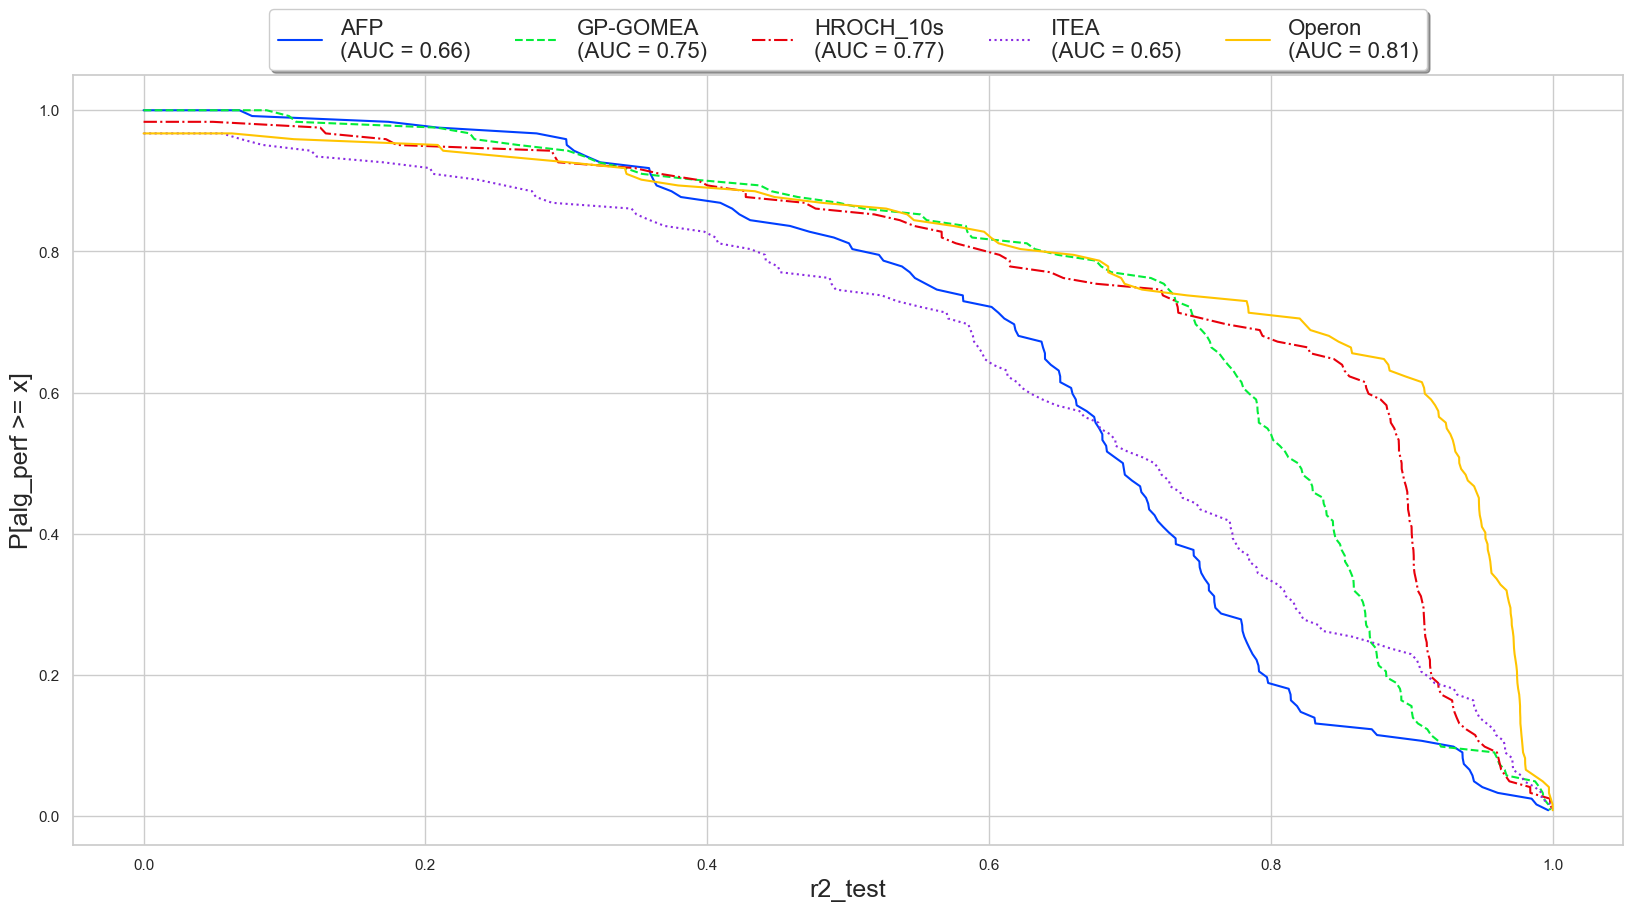

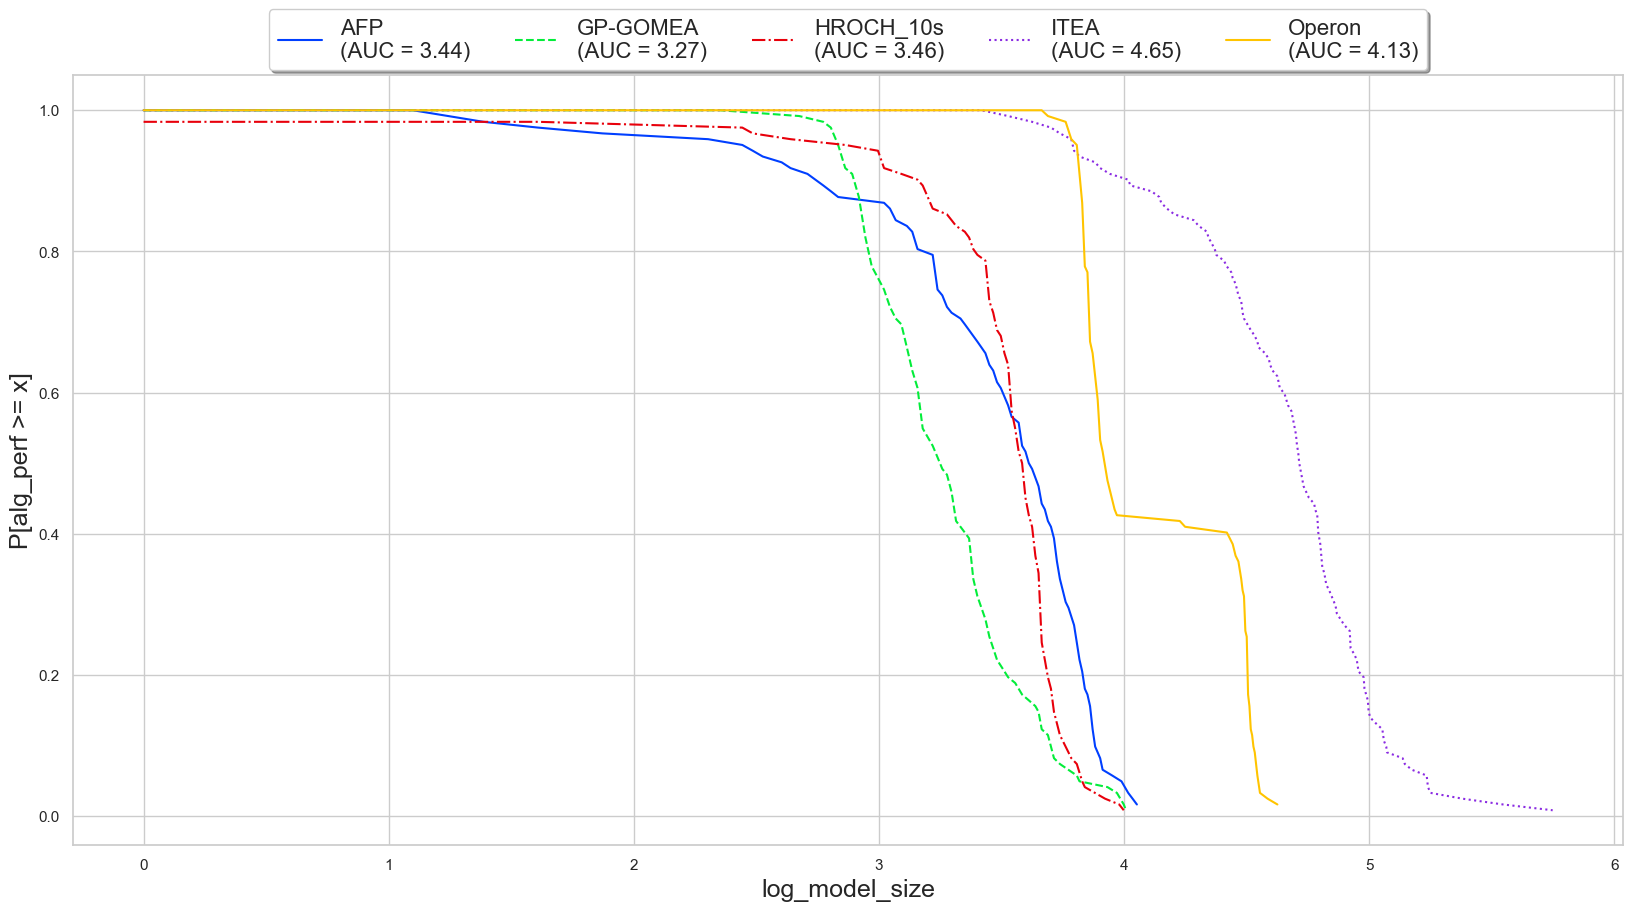

In [31]:
from collections import Counter
from itertools import cycle
from sklearn.metrics import auc
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-bright')

def perfprof_plot(df, perf_measure):
    lines = ["-","--","-.",":"]
    linecycler = cycle(lines)
    
    plt.figure(figsize=(20,10))
    tab = df.pivot(index="algorithm", columns="dataset", values=perf_measure)
    n_problems = len(tab.columns)
    for name, v in tab.iterrows():
        v = v[v>=0].sort_values()
        n_gt0 = v.shape[0]
        perf_x = [0]
        perf_y = [n_gt0/n_problems]
        for k, v1 in Counter(v).items():
            if k == 0:
                n_gt0 = n_gt0 - v1
                continue
            perf_x.append(k)
            perf_y.append(n_gt0/n_problems)
            n_gt0 = n_gt0 - v1

        plt.plot(perf_x, perf_y, next(linecycler), label=f'{name}\n(AUC = {np.round(auc(perf_x, perf_y),2)})')
    
    plt.xlabel(perf_measure, fontsize=18)
    plt.ylabel("P[alg_perf >= x]", fontsize=18)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
              ncol=10, fancybox=True, shadow=True, prop={'size': 16})

df_plot = df_sum    
df_plot["log_model_size"] = np.log(df_plot.model_size)
algs = ["AFP", "uDSR", "HROCH_10s", "GP-GOMEA", "Operon", "PS-Tree", "ITEA"]
perfprof_plot(df_plot, "r2_test")
plt.savefig("r2_perf_full.png")
perfprof_plot(df_plot[df_plot.algorithm.isin(algs)], "r2_test")
plt.savefig("r2_perf.png")
perfprof_plot(df_plot[df_plot.algorithm.isin(algs)], "log_model_size")
plt.savefig("size_perf.png")